In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs

Using TensorFlow backend.


In [4]:
input_file = codecs.open("socialmedia_relevant_cols.csv", "r", encoding='utf=8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [5]:
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv")
questions.columns=['text','choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [6]:
questions.tail()

,text,choose_one,class_label
10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,Relevant,1
10872,Police investigating after an e-bike collided ...,Relevant,1
10873,The Latest: More Homes Razed by Northern Calif...,Relevant,1
10874,MEG issues Hazardous Weather Outlook (HWO) htt...,Relevant,1
10875,#CityofCalgary has activated its Municipal Eme...,Relevant,1


In [7]:
questions.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [8]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(questions, 'text')

questions.to_csv("clean_data.csv")
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [9]:
clean_questions = pd.read_csv("clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10871,10871,m1 94 01 04 utc ?5km s of volcano hawaii,Relevant,1
10872,10872,police investigating after an e bike collided ...,Relevant,1
10873,10873,the latest more homes razed by northern calif...,Relevant,1
10874,10874,meg issues hazardous weather outlook (hwo),Relevant,1
10875,10875,cityofcalgary has activated its municipal eme...,Relevant,1


In [10]:
clean_questions.groupby("class_label").count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6187,6187,6187
1,4673,4673,4673
2,16,16,16


In [11]:
from nltk import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()
                             

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print ("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print ("Max sentence length is %s" % max(sentence_lengths))

154724 words total, with a vocabulary size of 18101
Max sentence length is 34


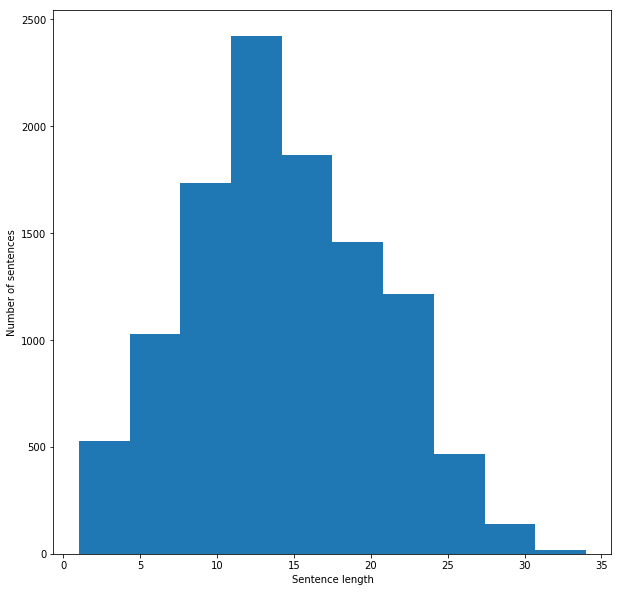

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()
    
    emb = count_vectorizer.fit_transform(data)
    
    return emb, count_vectorizer

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)


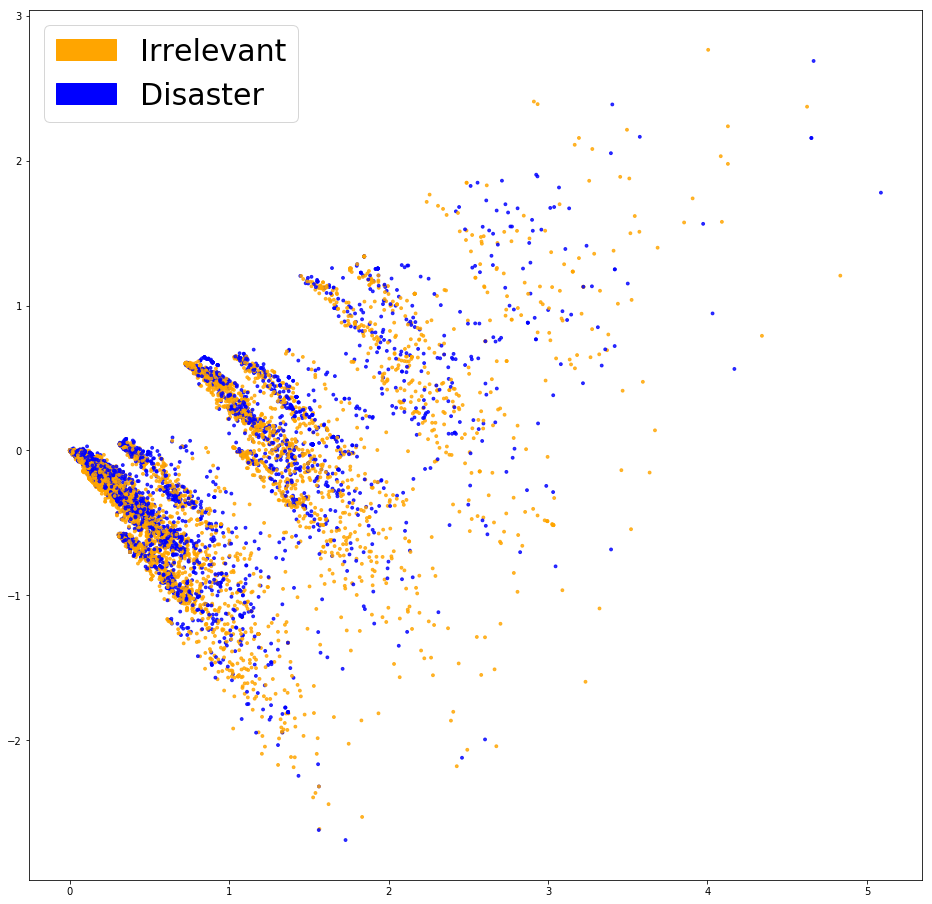

In [19]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()